In [2]:
import os
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import seaborn as sns
import torchvision.transforms as tt
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
from PIL import Image
%matplotlib inline

In [2]:
print(f"version: {torch.__version__}")
print(f"Is MPS Build? {torch.backends.mps.is_built()}")
device = "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using device: {device}")

version: 2.3.1
Is MPS Build? True
Using device: mps


Total number of categories: 151
Total number of images in dataset: 33971


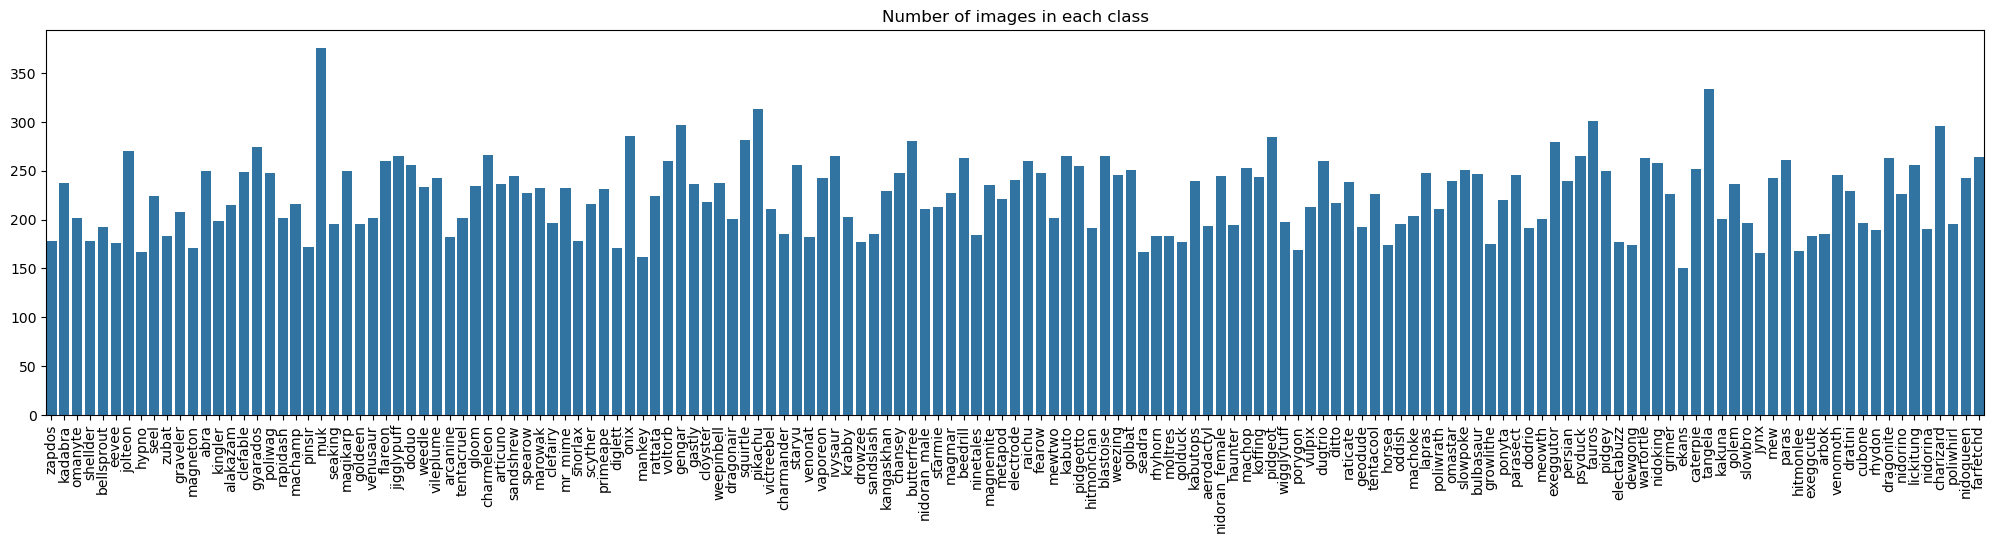

In [15]:
# Download Pokemon Dataset
path = '../pokemon_data' 
classes = [d for d in os.listdir(path) if os.path.isdir(os.path.join(path, d))]
print(f'Total number of categories: {len(classes)}')

class_counts = {}
for c in classes:
    class_counts[c] = len(os.listdir(os.path.join(path, c)))

num_images = sum(list(class_counts.values()))
print(f'Total number of images in dataset: {num_images}')

fig = plt.figure(figsize=(25, 5))
sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values())).set_title('Number of images in each class')
plt.xticks(rotation=90)
plt.margins(x=0)
plt.show()

In [16]:
# Replicating validation sets
random_seed = 42
torch.manual_seed(random_seed)

dataset = ImageFolder(path)
validation_size = 4000
training_size = len(dataset) - validation_size
train_ds, val_ds = random_split(dataset,[training_size, validation_size])
len(train_ds), len(val_ds)

(29734, 4000)

/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


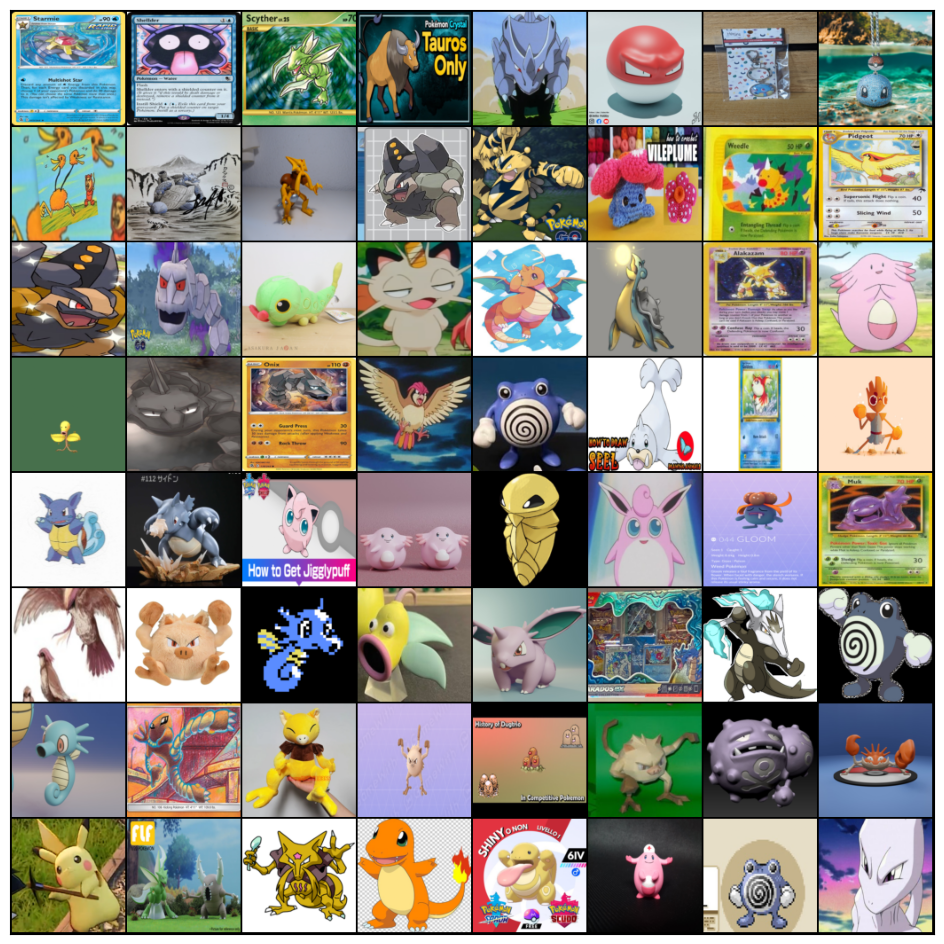

In [17]:
image_resize = (128, 128) 

# Crops of size 32x32, horizontal flip default probability of 50%
train_tfms = tt.Compose([tt.Resize(image_resize),
                        tt.RandomCrop(96, padding = 4, padding_mode='reflect'),
                        tt.RandomHorizontalFlip(),
                        tt.ToTensor()])
valid_tfms = tt.Compose([tt.Resize(image_resize), tt.ToTensor()])

train_ds.dataset.transform = train_tfms
val_ds.dataset.transform = valid_tfms


batch_size = 256
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)
valid_dl = DataLoader(val_ds, batch_size*2, num_workers=3, pin_memory=True)

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12,12))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images[:64], nrow=8).permute(1,2,0))
        break
        
show_batch(train_dl)

In [18]:
# Function to calculate mean and standard deviation
def calculate_mean_std(loader):
    mean = 0.0
    std = 0.0
    total_images_count = 0
    for images, _ in loader:
        batch_samples = images.size(0)
        images = images.view(batch_samples, images.size(1), -1)
        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)
        total_images_count += batch_samples

    mean /= total_images_count
    std /= total_images_count
    return mean, std

# Calculate mean and std for training data
train_mean, train_std = calculate_mean_std(train_dl)

print(f"Mean: {train_mean}")
print(f"Standard Deviation: {train_std}")

/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Mean: tensor([0.6055, 0.5916, 0.5546])
Standard Deviation: tensor([0.2221, 0.2112, 0.2234])


In [8]:
# Pick GPU, else CPU
def get_default_device():
    if torch.backends.mps.is_available():
        return torch.device('mps')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]  # Grab each tensor from the list of tensors
    return data.to(device, non_blocking=True)         # Copies data from cpu to gpu, non_blocking allows parallel execution

class DeviceDataLoader():
   
    # Wrap the dataloader to move data to a device
    def __init__(self, dataloader, device):
        self.dataloder = dataloader
        self.device = device
        
    # Yield a batch of data after moving it to device
    # Returns iterator
    def __iter__(self):
        for batch in self.dataloder:
            yield to_device(batch, self.device)
            
    def __len__(self):
        # Number of batches
        return len(self.dataloder)
    
device = get_default_device()
device

device(type='mps')

/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


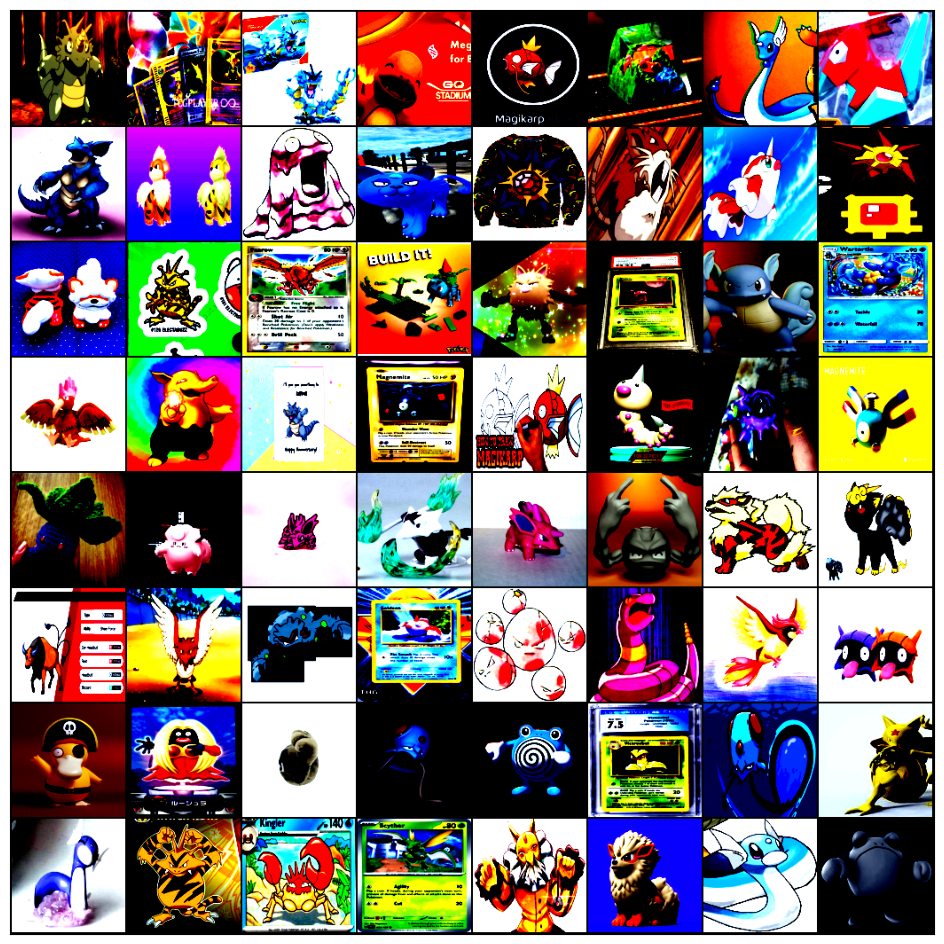

In [19]:
# Update transforms with calculated mean and std
stats = (train_mean.tolist(), train_std.tolist())

image_resize = (128, 128) 

train_tfms = tt.Compose([
    tt.Resize(image_resize),
    tt.RandomCrop(128, padding=4, padding_mode='reflect'),
    tt.RandomHorizontalFlip(),
    tt.RandomRotation(degrees=15),
    tt.RandomGrayscale(p=0.1),
    tt.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    tt.RandomAffine(degrees=345, translate=(0.1, 0.1), scale=(0.9, 1.1), shear=10),
    tt.RandomErasing(p=0.2, scale=(0.02, 0.2), ratio=(0.3, 3.3)),
    tt.ToTensor(),
    tt.Normalize(*stats, inplace=True)
])

valid_tfms = tt.Compose([
    tt.Resize(image_resize),
    tt.ToTensor(),
    tt.Normalize(*stats)
])

# Apply the updated transforms
train_ds.dataset.transform = train_tfms
val_ds.dataset.transform = valid_tfms

batch_size = 256

# Re-define data loaders if necessary
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)
valid_dl = DataLoader(val_ds, batch_size, num_workers=3, pin_memory=True)

show_batch(train_dl)

In [4]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        return loss
    
    # Calculates loss and accuracy relative to each batch
    # Returns dictionary of loss and accuracy
    def validation_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        return {'validation_loss': loss.detach(), 'validation_accuracy': acc.detach()}  # Detaches loss and acc from other model info stored from how it was derived
    
    # Receives list of dictionaries containing loss and accuracy
    # Finds the mean loss and the mean accuracy for the entire epoch 
    def validation_epoch_end(self, outputs):
        batch_losses = [x['validation_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()                                   # converts list of tensors into one tensor and extracts mean
        batch_accs = [x['validation_accuracy'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {'validation_loss': epoch_loss.item(), 'validation_accuracy': epoch_acc.item()}
    
    # Prints epoch summary of loss and accuracy as taken from validation_epoch_end function above
    # Training loss is new
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5}, train_loss: {:.4f}, validation_loss: {:.4f}, validation_accuracy: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['validation_loss'], result['validation_accuracy']))
        
# Stores 1 for correct, 0 for false
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    total_correct = torch.sum(preds == labels).item()
    total_predictions = len(preds)
    return torch.tensor(total_correct / total_predictions)

In [5]:
def conv_block(in_channels, out_channels, pool=False, dropout_rate=0.2):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
              nn.BatchNorm2d(out_channels),     
              nn.ReLU(inplace=True)]
    if pool:
        # Optional: Every 4 pixels replaced with 1
        layers.append(nn.MaxPool2d(2))
    if dropout_rate > 0:
        layers.append(nn.Dropout(dropout_rate))
    return nn.Sequential(*layers)                                              # List of layers to pass through

class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes, dropout_rate=0.2):
        super().__init__()
        
        # in_channels -> 64 channels -> 128 channels
        # When pool=True, image dimensions are halved
        self.conv1 = conv_block(in_channels, 64, pool=False, dropout_rate=dropout_rate)                   # 64 x 96 x 96
        self.conv2 = conv_block(64, 128, pool=True, dropout_rate=dropout_rate)                            # 128 x 48 x 48
        self.res1 = nn.Sequential(conv_block(128, 128, pool=False, dropout_rate=dropout_rate), 
                                  conv_block(128, 128, pool=False, dropout_rate=dropout_rate))  # 2 convolutional blocks without pooling or channel change
        
        self.conv3 = conv_block(128, 256, pool=True, dropout_rate=dropout_rate)                           # 256 x 24 x 24
        self.conv4 = conv_block(256, 512, pool=True, dropout_rate=dropout_rate)                           # 512 x 12 x 12
        self.res2 = nn.Sequential(conv_block(512, 512, pool=False, dropout_rate=dropout_rate), 
                                  conv_block(512, 512, pool=False, dropout_rate=dropout_rate))  # 512 x 12 x 12
        
        self.classifier = nn.Sequential(nn.MaxPool2d(12),                       # 512 x 1 x 1
                                        nn.Flatten(), 
                                        nn.Dropout(dropout_rate),              # 512
                                        nn.Linear(512, num_classes))           # 151 outputs
        
    # Method to set dropout rate
    def set_dropout_rate(self, dropout_rate):
        self.dropout_rate = dropout_rate
        for module in self.modules():
            if isinstance(module, nn.Dropout):
                module.p = dropout_rate
        
    def forward(self, xb):
        # input -> 2 conv layers -> res layer + prev output -> 2 conv layers -> res layer + prev output -> Pool -> Flatten -> Linear
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [14]:
# Calls the validation step for all batches
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()                          # Turns off nn.Dropout
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

# Trains model
def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    
    torch.cuda.empty_cache()
    history = []
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs,
                                               steps_per_epoch=len(train_loader))
    for epoch in range(epochs):
        # Training phase
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()              # Calculates gradients
            
            # Gradient Clipping
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
                
            optimizer.step()             # Gradient descent
            optimizer.zero_grad()
            lrs.append(get_lr(optimizer))
            sched.step()
            
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)   # Log epoch info
        history.append(result)           # Append validation loss and accuracy to history
    return history

In [21]:
import gc 
from torch import mps

gc.collect()
mps.empty_cache()

In [22]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)
model = to_device(ResNet9(3, 151), device)
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.2, inplace=False)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.2, inplace=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Dropout(p=0.2, inplace=False)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

In [23]:
history = [evaluate(model, valid_dl)]
history

/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


[{'validation_loss': 5.220158576965332,
  'validation_accuracy': 0.007275390438735485}]

In [24]:
epochs = 50
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam
history += fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl, grad_clip=grad_clip,
                         weight_decay=weight_decay, opt_func=opt_func)

/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Tran

Epoch [0], last_lr: 0.00050323, train_loss: 5.1265, validation_loss: 4.4390, validation_accuracy: 0.0614


/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Tran

Epoch [1], last_lr: 0.00081196, train_loss: 4.3484, validation_loss: 4.1223, validation_accuracy: 0.0986


/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Tran

Epoch [2], last_lr: 0.0013127, train_loss: 3.9710, validation_loss: 3.7775, validation_accuracy: 0.1536


/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Tran

Epoch [3], last_lr: 0.0019835, train_loss: 3.5829, validation_loss: 3.4233, validation_accuracy: 0.2397


/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Tran

Epoch [4], last_lr: 0.002795, train_loss: 3.1727, validation_loss: 3.0130, validation_accuracy: 0.3187


/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Tran

Epoch [5], last_lr: 0.0037118, train_loss: 2.8189, validation_loss: 2.8267, validation_accuracy: 0.3626


/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Tran

Epoch [6], last_lr: 0.0046937, train_loss: 2.5448, validation_loss: 2.7322, validation_accuracy: 0.3773


/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Tran

Epoch [7], last_lr: 0.0056977, train_loss: 2.2951, validation_loss: 2.4560, validation_accuracy: 0.4519


/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Tran

Epoch [8], last_lr: 0.00668, train_loss: 2.1152, validation_loss: 2.3076, validation_accuracy: 0.4925


/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Tran

Epoch [9], last_lr: 0.0075975, train_loss: 1.9552, validation_loss: 2.1813, validation_accuracy: 0.4811


/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Tran

Epoch [10], last_lr: 0.0084101, train_loss: 1.8209, validation_loss: 2.0867, validation_accuracy: 0.5162


/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Tran

Epoch [11], last_lr: 0.0090823, train_loss: 1.7133, validation_loss: 2.3068, validation_accuracy: 0.4739


/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Tran

Epoch [12], last_lr: 0.0095846, train_loss: 1.6541, validation_loss: 2.2202, validation_accuracy: 0.5229


/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Tran

Epoch [13], last_lr: 0.009895, train_loss: 1.6021, validation_loss: 2.0097, validation_accuracy: 0.5352


/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Tran

Epoch [14], last_lr: 0.01, train_loss: 1.5247, validation_loss: 1.6635, validation_accuracy: 0.6184


/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Tran

Epoch [15], last_lr: 0.0099799, train_loss: 1.4461, validation_loss: 1.6822, validation_accuracy: 0.6164


/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Tran

Epoch [16], last_lr: 0.0099196, train_loss: 1.4156, validation_loss: 1.8084, validation_accuracy: 0.5931


/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Tran

Epoch [17], last_lr: 0.0098198, train_loss: 1.3543, validation_loss: 1.5689, validation_accuracy: 0.6514


/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Tran

Epoch [18], last_lr: 0.0096812, train_loss: 1.3137, validation_loss: 1.5577, validation_accuracy: 0.6404


/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Tran

Epoch [19], last_lr: 0.0095048, train_loss: 1.2724, validation_loss: 1.6503, validation_accuracy: 0.6158


/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Tran

Epoch [20], last_lr: 0.0092922, train_loss: 1.2462, validation_loss: 1.5749, validation_accuracy: 0.6428


/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Tran

Epoch [21], last_lr: 0.0090451, train_loss: 1.2081, validation_loss: 1.6824, validation_accuracy: 0.6398


/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Tran

Epoch [22], last_lr: 0.0087654, train_loss: 1.1490, validation_loss: 1.3371, validation_accuracy: 0.6906


/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Tran

Epoch [23], last_lr: 0.0084553, train_loss: 1.4191, validation_loss: 1.6839, validation_accuracy: 0.6348


/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Tran

Epoch [24], last_lr: 0.0081175, train_loss: 1.1074, validation_loss: 1.5720, validation_accuracy: 0.6480


/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Tran

Epoch [25], last_lr: 0.0077545, train_loss: 1.0511, validation_loss: 1.3683, validation_accuracy: 0.6965


/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Tran

Epoch [26], last_lr: 0.0073694, train_loss: 1.0065, validation_loss: 21.0513, validation_accuracy: 0.0082


/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Tran

Epoch [27], last_lr: 0.0069651, train_loss: 1.0370, validation_loss: 1.1858, validation_accuracy: 0.7320


/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Tran

Epoch [28], last_lr: 0.0065451, train_loss: 0.9086, validation_loss: 1.1496, validation_accuracy: 0.7373


/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Tran

Epoch [29], last_lr: 0.0061126, train_loss: 0.8691, validation_loss: 1.2106, validation_accuracy: 0.7330


/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Tran

Epoch [30], last_lr: 0.0056712, train_loss: 0.7998, validation_loss: 1.1301, validation_accuracy: 0.7484


/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Tran

Epoch [31], last_lr: 0.0052243, train_loss: 0.7642, validation_loss: 1.0387, validation_accuracy: 0.7644


/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Tran

Epoch [32], last_lr: 0.0047757, train_loss: 0.7136, validation_loss: 0.9692, validation_accuracy: 0.7794


/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Tran

Epoch [33], last_lr: 0.0043289, train_loss: 0.6545, validation_loss: 0.9625, validation_accuracy: 0.7887


/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Tran

Epoch [34], last_lr: 0.0038874, train_loss: 0.5755, validation_loss: 0.9462, validation_accuracy: 0.7858


/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Tran

Epoch [35], last_lr: 0.0034549, train_loss: 0.5440, validation_loss: 0.9050, validation_accuracy: 0.8021


/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Tran

Epoch [36], last_lr: 0.0030349, train_loss: 0.4609, validation_loss: 0.8250, validation_accuracy: 0.8171


/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Tran

Epoch [37], last_lr: 0.0026307, train_loss: 0.3961, validation_loss: 0.7934, validation_accuracy: 0.8249


/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Tran

Epoch [38], last_lr: 0.0022455, train_loss: 0.3327, validation_loss: 0.8122, validation_accuracy: 0.8174


/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Tran

Epoch [39], last_lr: 0.0018826, train_loss: 0.2955, validation_loss: 0.7597, validation_accuracy: 0.8272


/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Tran

Epoch [40], last_lr: 0.0015447, train_loss: 0.2390, validation_loss: 0.7576, validation_accuracy: 0.8338


/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Tran

Epoch [41], last_lr: 0.0012347, train_loss: 0.1859, validation_loss: 0.7337, validation_accuracy: 0.8389


/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Tran

Epoch [42], last_lr: 0.00095495, train_loss: 0.1489, validation_loss: 0.7224, validation_accuracy: 0.8409


/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Tran

Epoch [43], last_lr: 0.00070779, train_loss: 0.1180, validation_loss: 0.6946, validation_accuracy: 0.8502


/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Tran

Epoch [44], last_lr: 0.00049519, train_loss: 0.1012, validation_loss: 0.6900, validation_accuracy: 0.8490


/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Tran

Epoch [45], last_lr: 0.00031886, train_loss: 0.0841, validation_loss: 0.6887, validation_accuracy: 0.8525


/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Tran

Epoch [46], last_lr: 0.00018022, train_loss: 0.0715, validation_loss: 0.6853, validation_accuracy: 0.8536


/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Tran

Epoch [47], last_lr: 8.0392e-05, train_loss: 0.0640, validation_loss: 0.6777, validation_accuracy: 0.8542


/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Tran

Epoch [48], last_lr: 2.0168e-05, train_loss: 0.0609, validation_loss: 0.6805, validation_accuracy: 0.8563


/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Tran

Epoch [49], last_lr: 4e-08, train_loss: 0.0597, validation_loss: 0.6784, validation_accuracy: 0.8542


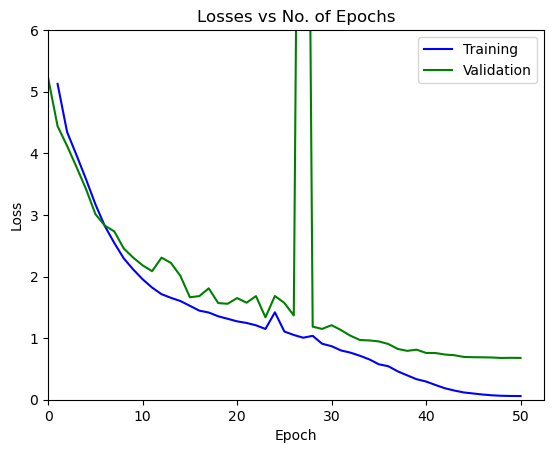

In [31]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['validation_loss'] for x in history]
    plt.plot(train_losses, '-b')
    plt.plot(val_losses, '-g')
    plt.ylim(top=6, bottom=0)
    plt.xlim(left=0)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Losses vs No. of Epochs')
    plt.show()
    
plot_losses(history)

Maximum Accuracy Reached: 0.8563476800918579%


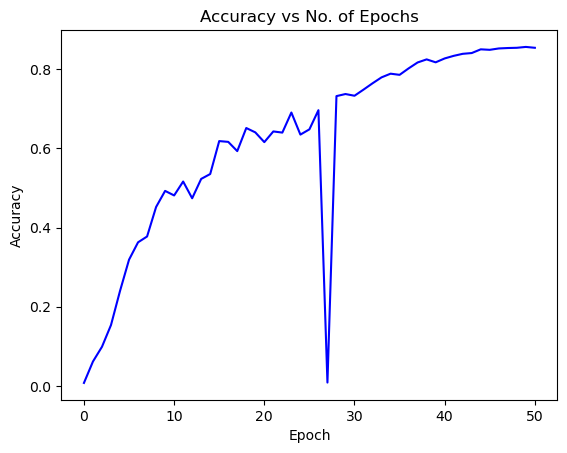

In [32]:
def plot_accuracies(history):
    accuracies = [x['validation_accuracy'] for x in history]
    max_accuracy = 0
    for a in accuracies:
        if (a > max_accuracy):
            max_accuracy = a
            
    print(f"Maximum Accuracy Reached: {max_accuracy}%")
    plt.plot(accuracies, 'b')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs No. of Epochs')
    plt.show()
  
plot_accuracies(history)

In [59]:
# Download Pokemon Dataset
test_path = '../dataset' 
test_classes = [d for d in os.listdir(test_path) if os.path.isdir(os.path.join(test_path, d))]
print(f'Total number of categories: {len(test_classes)}')

test_class_counts = {}
for c in test_classes:
    test_class_counts[c] = len(os.listdir(os.path.join(test_path, c)))
    
print(f'Total number of images in dataset: {sum(list(test_class_counts.values()))}')

Total number of categories: 149
Total number of images in dataset: 10658


In [60]:
# Convert test images to vectors
test_tfms = tt.Compose([tt.Resize(image_resize), tt.ToTensor()])
test_ds = ImageFolder(test_path, transform=test_tfms)
test_dl = DataLoader(test_ds, batch_size*2, shuffle=True, num_workers=3, pin_memory=True)

In [61]:
# Calculate mean and std for test data
test_mean, test_std = calculate_mean_std(test_dl)

print(f"Mean: {test_mean}")
print(f"Standard Deviation: {test_std}")

test_stats = (test_mean.tolist(), test_std.tolist())

Mean: tensor([0.6230, 0.6182, 0.5805])
Standard Deviation: tensor([0.2310, 0.2213, 0.2317])


In [62]:
# Normalize images and recreate Dataloader for Test Data
test_tfms = tt.Compose([tt.Resize(image_resize), tt.ToTensor(), tt.Normalize(*stats)])
test_ds = ImageFolder(test_path, transform=test_tfms)
test_dl = DataLoader(test_ds, batch_size*2, shuffle=True, num_workers=3, pin_memory=True)

In [68]:
def predict_image(img, model, dataset):
    xb = img.unsqueeze(0)
    yb = model(xb)
    _, preds = torch.max(yb, dim=1)
    print(preds, dataset.classes[preds[0].item()])
    return dataset.classes[preds[0].item()]          

def get_test_accuracy(total_correct, test_dataset):
    test_percent_accuracy = (num_correct / len(test_dataset)) * 100
    print(f"Test Accuracy: {test_percent_accuracy}%")

count = 0
num_correct = 0
model_verify.set_dropout_rate(0)
for img, label in test_ds:
    count += 1
    prediction = (predict_image(img, model_verify, test_ds)).lower()
    actual = (test_ds.classes[label]).lower()
    print(actual, prediction)
    if actual == "mrmime":
        actual = "mr_mime"
    if actual == prediction:
        num_correct += 1

get_test_accuracy(num_correct, test_ds)

tensor([0]) Abra
abra abra
tensor([0]) Abra
abra abra
tensor([0]) Abra
abra abra
tensor([0]) Abra
abra abra
tensor([0]) Abra
abra abra
tensor([0]) Abra
abra abra
tensor([0]) Abra
abra abra
tensor([0]) Abra
abra abra
tensor([0]) Abra
abra abra
tensor([0]) Abra
abra abra
tensor([0]) Abra
abra abra
tensor([0]) Abra
abra abra
tensor([2]) Alakazam
abra alakazam
tensor([0]) Abra
abra abra
tensor([0]) Abra
abra abra
tensor([0]) Abra
abra abra
tensor([0]) Abra
abra abra
tensor([0]) Abra
abra abra
tensor([119]) Seadra
abra seadra
tensor([0]) Abra
abra abra
tensor([0]) Abra
abra abra
tensor([0]) Abra
abra abra
tensor([0]) Abra
abra abra
tensor([0]) Abra
abra abra
tensor([0]) Abra
abra abra
tensor([0]) Abra
abra abra
tensor([0]) Abra
abra abra
tensor([0]) Abra
abra abra
tensor([0]) Abra
abra abra
tensor([0]) Abra
abra abra
tensor([0]) Abra
abra abra
tensor([0]) Abra
abra abra
tensor([61]) Kabutops
abra kabutops
tensor([0]) Abra
abra abra
tensor([0]) Abra
abra abra
tensor([0]) Abra
abra abra
tenso

IndexError: list index out of range

In [50]:
save_path = os.path.join('saved_models', 'Model85')
torch.save(model, save_path)

In [51]:
# Model class must be defined somewhere
model_reload = torch.load(save_path)
model_reload

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0, inplace=False)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0, inplace=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Dropout(p=0, inplace=False)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     

In [56]:
count = 0
num_correct = 0
model.set_dropout_rate(0)
for img, label in test_ds:
    count += 1
    prediction = (predict_image(img, model_reload, dataset)).lower()
    actual = (test_ds.classes[label]).lower()
    if actual == "mrmime":
        actual = "mr_mime"
    if actual == prediction:
        num_correct += 1

get_test_accuracy(num_correct, test_ds)

Test Accuracy: 83.34428075443371%


In [58]:
evaluate(model_reload, valid_dl)

/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


{'validation_loss': 0.6784207820892334,
 'validation_accuracy': 0.8541504144668579}

In [6]:
save_path = os.path.join('saved_models', 'Model85')

# Model class must be defined somewhere
model_load2 = torch.load(save_path)

In [7]:
model_load2

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0, inplace=False)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0, inplace=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Dropout(p=0, inplace=False)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     

In [12]:
torch.save(model_load2.state_dict(), 'Model85_state_dict.pth')
state_dict_path = 'Model85_state_dict.pth'

In [13]:
model_verify = ResNet9(in_channels=3, num_classes=151, dropout_rate=0.2)
model_verify.load_state_dict(torch.load(state_dict_path, map_location=torch.device('cpu')))

<All keys matched successfully>

In [21]:
evaluate(model_verify, valid_dl)

/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


{'validation_loss': 0.6784205436706543,
 'validation_accuracy': 0.8541504144668579}

In [49]:
img, label = train_ds[18]
print(label)
print('img tensor', img)

146
img tensor tensor([[[1.7766, 1.7766, 1.7766,  ..., 1.7766, 1.7766, 1.7766],
         [1.7766, 1.7766, 1.7766,  ..., 1.7766, 1.7766, 1.7766],
         [1.7766, 1.7766, 1.7766,  ..., 1.7766, 1.7766, 1.7766],
         ...,
         [1.7766, 1.7766, 1.7766,  ..., 1.7766, 1.7766, 1.7766],
         [1.7766, 1.7766, 1.7766,  ..., 1.7766, 1.7766, 1.7766],
         [1.7766, 1.7766, 1.7766,  ..., 1.7766, 1.7766, 1.7766]],

        [[1.9335, 1.9335, 1.9335,  ..., 1.9335, 1.9335, 1.9335],
         [1.9335, 1.9335, 1.9335,  ..., 1.9335, 1.9335, 1.9335],
         [1.9335, 1.9335, 1.9335,  ..., 1.9335, 1.9335, 1.9335],
         ...,
         [1.9335, 1.9335, 1.9335,  ..., 1.9335, 1.9335, 1.9335],
         [1.9335, 1.9335, 1.9335,  ..., 1.9335, 1.9335, 1.9335],
         [1.9335, 1.9335, 1.9335,  ..., 1.9335, 1.9335, 1.9335]],

        [[1.9939, 1.9939, 1.9939,  ..., 1.9939, 1.9939, 1.9939],
         [1.9939, 1.9939, 1.9939,  ..., 1.9939, 1.9939, 1.9939],
         [1.9939, 1.9939, 1.9939,  ..., 1.9

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


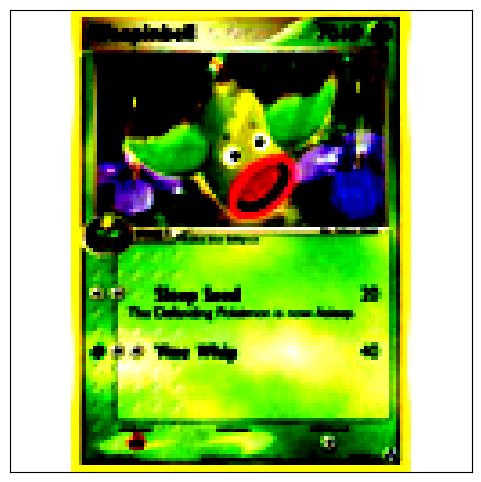

In [50]:
fig, ax = plt.subplots(figsize=(6,6))
ax.set_xticks([]); ax.set_yticks([])
ax.imshow(make_grid(img, nrow=1).permute(1,2,0))

In [51]:
def predict(img, model, dataset):
    print('predict_image')
    xb = img.unsqueeze(0)
    yb = model(xb)
    _, preds = torch.max(yb, dim=1)
    print(preds)
    return dataset.classes[preds[0].item()]

predict(img, model_verify, train_ds)

predict_image
tensor([146])


AttributeError: 'Subset' object has no attribute 'classes'

In [55]:
count = 0

for c in classes:
    print(count, c)
    count += 1

0 zapdos
1 kadabra
2 omanyte
3 shellder
4 bellsprout
5 eevee
6 jolteon
7 hypno
8 seel
9 zubat
10 graveler
11 magneton
12 abra
13 kingler
14 alakazam
15 clefable
16 gyarados
17 poliwag
18 rapidash
19 machamp
20 pinsir
21 muk
22 seaking
23 magikarp
24 goldeen
25 venusaur
26 flareon
27 jigglypuff
28 doduo
29 weedle
30 vileplume
31 arcanine
32 tentacruel
33 gloom
34 charmeleon
35 articuno
36 sandshrew
37 spearow
38 marowak
39 clefairy
40 mr_mime
41 snorlax
42 scyther
43 primeape
44 diglett
45 onix
46 mankey
47 rattata
48 voltorb
49 gengar
50 gastly
51 cloyster
52 weepinbell
53 dragonair
54 squirtle
55 pikachu
56 victreebel
57 charmander
58 staryu
59 venonat
60 vaporeon
61 ivysaur
62 krabby
63 drowzee
64 sandslash
65 kangaskhan
66 chansey
67 butterfree
68 nidoran_male
69 starmie
70 magmar
71 beedrill
72 ninetales
73 magnemite
74 metapod
75 electrode
76 raichu
77 fearow
78 mewtwo
79 kabuto
80 pidgeotto
81 hitmonchan
82 blastoise
83 weezing
84 golbat
85 seadra
86 rhyhorn
87 moltres
88 golduck

In [88]:
len(val_ds)

4000

In [90]:
# Function to get all labels
def get_all_labels(dataset):
    labels = []
    for _, label in dataset:
        print(label, dataset.classes[label])
        labels.append(label)
    return labels

get_all_labels(val_ds)

AttributeError: 'Subset' object has no attribute 'classes'

In [97]:
test_img, test_label = test_ds[2008]
print(test_img, test_label)

tensor([[[-1.4197, -1.4373, -1.4550,  ...,  0.5758,  0.5935,  0.5581],
         [-1.4197, -1.4373, -1.4373,  ...,  0.5581,  0.5758,  0.5581],
         [-1.3843, -1.4197, -1.4197,  ...,  0.5228,  0.5581,  0.5581],
         ...,
         [-0.5720, -0.6074, -0.6074,  ...,  1.4764,  1.4234,  1.4058],
         [-0.5897, -0.6074, -0.6074,  ...,  1.5294,  1.3881,  1.3528],
         [-0.5720, -0.6074, -0.5897,  ...,  1.5294,  1.3705,  1.3351]],

        [[-0.5545, -0.5545, -0.5731,  ...,  1.8964,  1.9149,  1.9149],
         [-0.5545, -0.5545, -0.5545,  ...,  1.8592,  1.8778,  1.9149],
         [-0.5359, -0.5359, -0.5359,  ...,  1.8221,  1.8407,  1.8407],
         ...,
         [ 0.5038,  0.4853,  0.4853,  ...,  1.9149,  1.8964,  1.8964],
         [ 0.5038,  0.4853,  0.4853,  ...,  1.8964,  1.8778,  1.8592],
         [ 0.5038,  0.4853,  0.5038,  ...,  1.8964,  1.8592,  1.8221]],

        [[-0.3232, -0.3232, -0.3408,  ...,  1.9764,  1.9764,  1.9588],
         [-0.3232, -0.3232, -0.3232,  ...,  1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


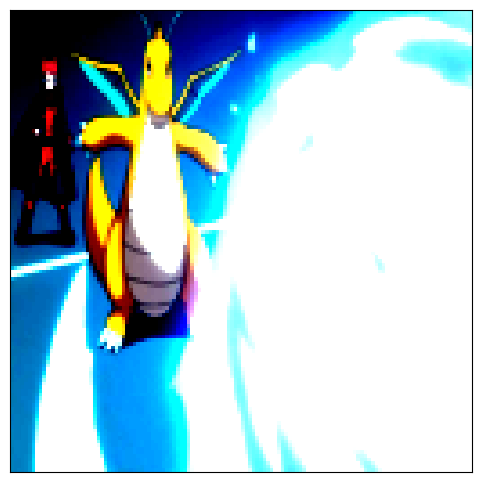

In [98]:
fig, ax = plt.subplots(figsize=(6,6))
ax.set_xticks([]); ax.set_yticks([])
ax.imshow(make_grid(test_img, nrow=1).permute(1,2,0))

In [99]:
predict(test_img, model_verify, test_ds)

predict_image
tensor([26])


'Dragonite'

In [93]:
i = 0
while i < len(dataset.classes):
    print(i, dataset.classes[i])
    i += 1

0 abra
1 aerodactyl
2 alakazam
3 arbok
4 arcanine
5 articuno
6 beedrill
7 bellsprout
8 blastoise
9 bulbasaur
10 butterfree
11 caterpie
12 chansey
13 charizard
14 charmander
15 charmeleon
16 clefable
17 clefairy
18 cloyster
19 cubone
20 dewgong
21 diglett
22 ditto
23 dodrio
24 doduo
25 dragonair
26 dragonite
27 dratini
28 drowzee
29 dugtrio
30 eevee
31 ekans
32 electabuzz
33 electrode
34 exeggcute
35 exeggutor
36 farfetchd
37 fearow
38 flareon
39 gastly
40 gengar
41 geodude
42 gloom
43 golbat
44 goldeen
45 golduck
46 golem
47 graveler
48 grimer
49 growlithe
50 gyarados
51 haunter
52 hitmonchan
53 hitmonlee
54 horsea
55 hypno
56 ivysaur
57 jigglypuff
58 jolteon
59 jynx
60 kabuto
61 kabutops
62 kadabra
63 kakuna
64 kangaskhan
65 kingler
66 koffing
67 krabby
68 lapras
69 lickitung
70 machamp
71 machoke
72 machop
73 magikarp
74 magmar
75 magnemite
76 magneton
77 mankey
78 marowak
79 meowth
80 metapod
81 mew
82 mewtwo
83 moltres
84 mr_mime
85 muk
86 nidoking
87 nidoqueen
88 nidoran_female
89

In [1]:
import os
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import seaborn as sns
import torchvision.transforms as tt
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
from PIL import Image
%matplotlib inline

In [2]:
# Precomputed normalization statistics
test_mean = torch.tensor([0.6055, 0.5916, 0.5546])
test_std = torch.tensor([0.2221, 0.2112, 0.2234])
test_stats = (test_mean.tolist(), test_std.tolist())

In [4]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        return loss
    
    # Calculates loss and accuracy relative to each batch
    # Returns dictionary of loss and accuracy
    def validation_step(self, batch):
        print('validation step start')
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        print('validation step end')
        return {'validation_loss': loss.detach(), 'validation_accuracy': acc.detach()}  # Detaches loss and acc from other model info stored from how it was derived
    
    # Receives list of dictionaries containing loss and accuracy
    # Finds the mean loss and the mean accuracy for the entire epoch 
    def validation_epoch_end(self, outputs):
        batch_losses = [x['validation_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()                                   # converts list of tensors into one tensor and extracts mean
        batch_accs = [x['validation_accuracy'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        print('validation_loss: ', epoch_loss.item(), 'validation_accuracy:', epoch_acc.item())
        return {'validation_loss': epoch_loss.item(), 'validation_accuracy': epoch_acc.item()}
    
    # Prints epoch summary of loss and accuracy as taken from validation_epoch_end function above
    # Training loss is new
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5}, train_loss: {:.4f}, validation_loss: {:.4f}, validation_accuracy: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['validation_loss'], result['validation_accuracy']))
# Stores 1 for correct, 0 for false
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    total_correct = torch.sum(preds == labels).item()
    total_predictions = len(preds)
    return torch.tensor(total_correct / total_predictions)

def conv_block(in_channels, out_channels, pool=False, dropout_rate=0.2):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
              nn.BatchNorm2d(out_channels),     
              nn.ReLU(inplace=True)]
    if pool:
        # Optional: Every 4 pixels replaced with 1
        layers.append(nn.MaxPool2d(2))
    if dropout_rate > 0:
        layers.append(nn.Dropout(dropout_rate))
    return nn.Sequential(*layers)                                              # List of layers to pass through

class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes, dropout_rate=0.2):
        super().__init__()
        
        # in_channels -> 64 channels -> 128 channels
        # When pool=True, image dimensions are halved
        self.conv1 = conv_block(in_channels, 64, pool=False, dropout_rate=dropout_rate)                   # 64 x 96 x 96
        self.conv2 = conv_block(64, 128, pool=True, dropout_rate=dropout_rate)                            # 128 x 48 x 48
        self.res1 = nn.Sequential(conv_block(128, 128, pool=False, dropout_rate=dropout_rate), 
                                  conv_block(128, 128, pool=False, dropout_rate=dropout_rate))  # 2 convolutional blocks without pooling or channel change
        
        self.conv3 = conv_block(128, 256, pool=True, dropout_rate=dropout_rate)                           # 256 x 24 x 24
        self.conv4 = conv_block(256, 512, pool=True, dropout_rate=dropout_rate)                           # 512 x 12 x 12
        self.res2 = nn.Sequential(conv_block(512, 512, pool=False, dropout_rate=dropout_rate), 
                                  conv_block(512, 512, pool=False, dropout_rate=dropout_rate))  # 512 x 12 x 12
        
        self.classifier = nn.Sequential(nn.MaxPool2d(12),                       # 512 x 1 x 1
                                        nn.Flatten(), 
                                        nn.Dropout(dropout_rate),              # 512
                                        nn.Linear(512, num_classes))           # 151 outputs
        
    # Method to set dropout rate
    def set_dropout_rate(self, dropout_rate):
        self.dropout_rate = dropout_rate
        for module in self.modules():
            if isinstance(module, nn.Dropout):
                module.p = dropout_rate
        
    def forward(self, xb):
        # input -> 2 conv layers -> res layer + prev output -> 2 conv layers -> res layer + prev output -> Pool -> Flatten -> Linear
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out
    

In [6]:
# Download Pokemon Dataset
path = '../pokemon_data' 
classes = [d for d in os.listdir(path) if os.path.isdir(os.path.join(path, d))]
print(f'Total number of categories: {len(classes)}')

class_counts = {}
for c in classes:
    class_counts[c] = len(os.listdir(os.path.join(path, c)))

num_images = sum(list(class_counts.values()))
print(f'Total number of images in dataset: {num_images}')

Total number of categories: 151
Total number of images in dataset: 33971


In [7]:
# Replicating validation sets
random_seed = 42
torch.manual_seed(random_seed)

dataset = ImageFolder(path)
validation_size = 4000
training_size = len(dataset) - validation_size
train_ds, val_ds = random_split(dataset,[training_size, validation_size])
len(train_ds), len(val_ds)

(29734, 4000)

/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


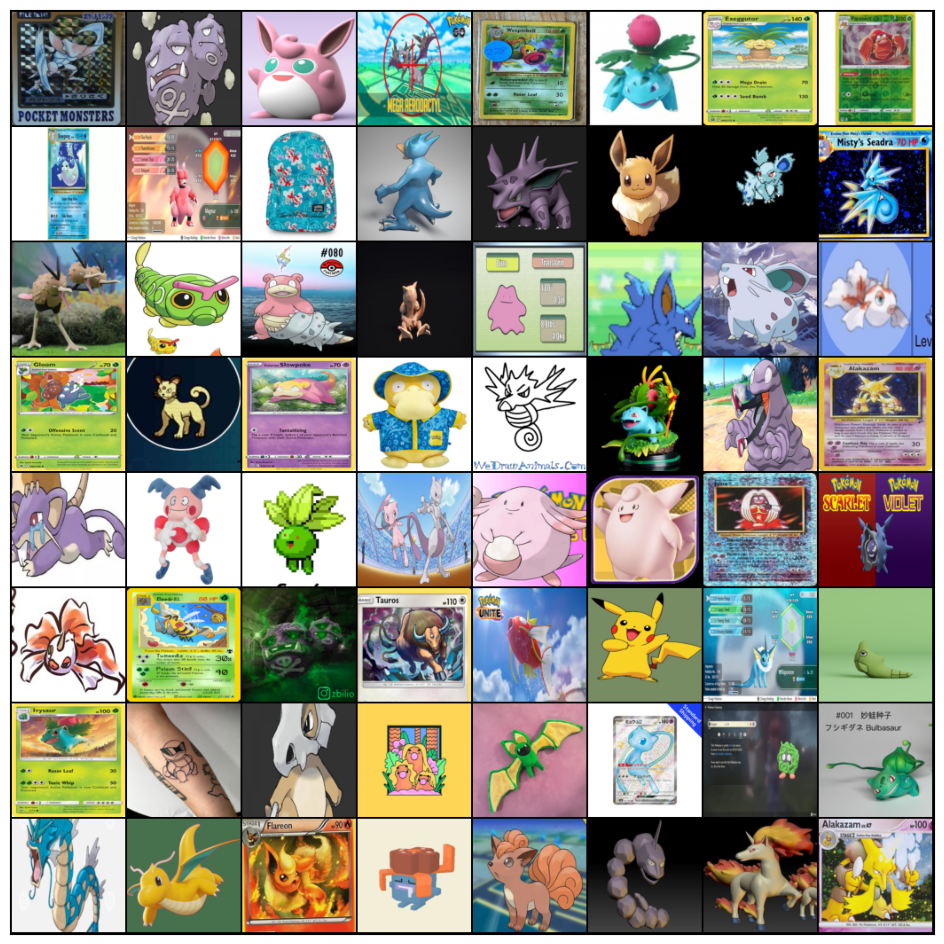

In [21]:
image_resize = (128, 128) 

# Crops of size 32x32, horizontal flip default probability of 50%
train_tfms = tt.Compose([tt.Resize(image_resize),
                        tt.RandomCrop(96, padding = 4, padding_mode='reflect'),
                        tt.RandomHorizontalFlip(),
                        tt.ToTensor()])
valid_tfms = tt.Compose([tt.Resize(image_resize), tt.ToTensor()])

train_ds.dataset.transform = train_tfms
val_ds.dataset.transform = valid_tfms


batch_size = 256
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)
valid_dl = DataLoader(val_ds, batch_size*2, num_workers=3, pin_memory=True)

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12,12))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images[:64], nrow=8).permute(1,2,0))
        break
        
show_batch(train_dl)

In [9]:
# Pick GPU, else CPU
def get_default_device():
    if torch.backends.mps.is_available():
        return torch.device('mps')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]  # Grab each tensor from the list of tensors
    return data.to(device, non_blocking=True)         # Copies data from cpu to gpu, non_blocking allows parallel execution

class DeviceDataLoader():
   
    # Wrap the dataloader to move data to a device
    def __init__(self, dataloader, device):
        self.dataloder = dataloader
        self.device = device
        
    # Yield a batch of data after moving it to device
    # Returns iterator
    def __iter__(self):
        for batch in self.dataloder:
            yield to_device(batch, self.device)
            
    def __len__(self):
        # Number of batches
        return len(self.dataloder)
    
device = get_default_device()
device

device(type='mps')

/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


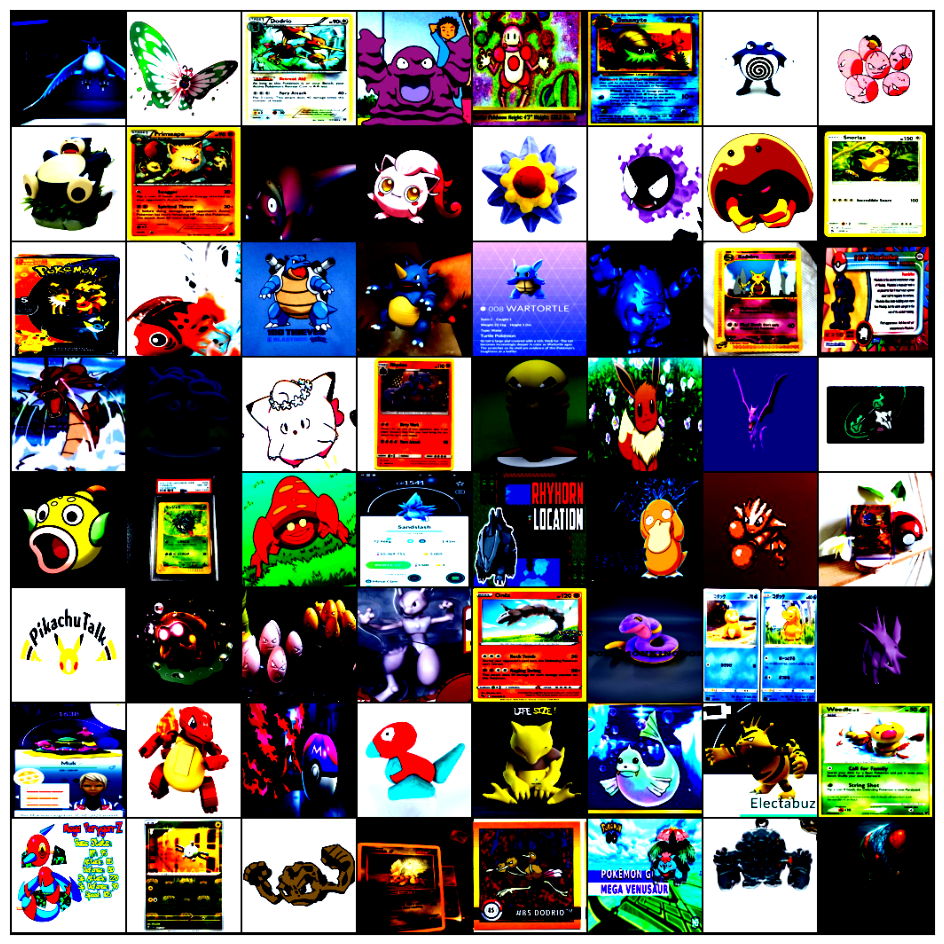

In [22]:
image_resize = (128, 128) 

train_tfms = tt.Compose([
    tt.Resize(image_resize),
    tt.RandomCrop(128, padding=4, padding_mode='reflect'),
    tt.RandomHorizontalFlip(),
    tt.RandomRotation(degrees=15),
    tt.RandomGrayscale(p=0.1),
    tt.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    tt.RandomAffine(degrees=345, translate=(0.1, 0.1), scale=(0.9, 1.1), shear=10),
    tt.RandomErasing(p=0.2, scale=(0.02, 0.2), ratio=(0.3, 3.3)),
    tt.ToTensor(),
    tt.Normalize(*test_stats, inplace=True)
])

valid_tfms = tt.Compose([
    tt.Resize(image_resize),
    tt.ToTensor(),
    tt.Normalize(*test_stats)
])

# Apply the updated transforms
train_ds.dataset.transform = train_tfms
val_ds.dataset.transform = valid_tfms

batch_size = 256

# Re-define data loaders if necessary
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)
valid_dl = DataLoader(val_ds, batch_size, num_workers=3, pin_memory=True)

show_batch(train_dl)

In [23]:
# train_dl = DeviceDataLoader(train_dl, device)
# valid_dl = DeviceDataLoader(valid_dl, device)
# Load model and put in evaluation mode
model = ResNet9(3, 151)
model.load_state_dict(torch.load('Model85_state_dict.pth', map_location=torch.device('cpu')))

<All keys matched successfully>

In [24]:
# Calls the validation step for all batches
# @torch.no_grad()
def evaluate(model, val_loader):
    model.eval()                          # Turns off nn.Dropout
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)
    
evaluate(model, valid_dl)

/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


validation step start
validation step end
validation step start
validation step end
validation step start
validation step end
validation step start
validation step end
validation step start
validation step end
validation step start
validation step end
validation step start
validation step end
validation step start
validation step end
validation step start
validation step end
validation step start
validation step end
validation step start
validation step end
validation step start
validation step end
validation step start
validation step end
validation step start
validation step end
validation step start
validation step end
validation step start
validation step end
validation_loss:  0.6784012913703918 validation_accuracy: 0.8541504144668579


{'validation_loss': 0.6784012913703918,
 'validation_accuracy': 0.8541504144668579}

In [25]:
# Download Pokemon Dataset
test_path = '../test_data' 
test_classes = [d for d in os.listdir(test_path) if os.path.isdir(os.path.join(test_path, d))]
print(f'Total number of categories: {len(test_classes)}')

test_class_counts = {}
for c in test_classes:
    test_class_counts[c] = len(os.listdir(os.path.join(test_path, c)))

test_num_images = sum(list(test_class_counts.values()))
print(f'Total number of images in dataset: {test_num_images}')

Total number of categories: 151
Total number of images in dataset: 4729


In [26]:
test_ds = ImageFolder(test_path)
image_resize = (128, 128) 

test_tfms = tt.Compose([tt.Resize(image_resize), tt.ToTensor(), tt.Normalize(*test_stats)])
test_ds.transform = test_tfms

In [27]:
def predict_image(img, model, dataset):
    # xb = to_device(img.unsqueeze(0), device)
    xb = img.unsqueeze(0)
    yb = model(xb)
    _, preds = torch.max(yb, dim=1)
    return dataset.classes[preds[0].item()]                         

def get_accuracy(model, dataset):
    count = 0
    num_correct = 0
    for img, label in dataset:
        count += 1
        prediction = (predict_image(img, model, test_ds)).lower()
        actual = (test_ds.classes[label]).lower()
        if actual == "mrmime":
            actual = "mr_mime"
        print(count, " - (", actual, ",", prediction, ")")
        if actual == prediction:
            num_correct += 1

    accuracy = num_correct/test_num_images
    return accuracy

In [28]:
accuracy = get_accuracy(model, test_ds)
print(f"Model Accuracy: {accuracy}")

tensor([0])
1  - ( abra , abra )
tensor([62])
2  - ( abra , kadabra )
tensor([0])
3  - ( abra , abra )
tensor([0])
4  - ( abra , abra )
tensor([0])
5  - ( abra , abra )
tensor([0])


/opt/anaconda3/lib/python3.12/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


6  - ( abra , abra )
tensor([0])
7  - ( abra , abra )
tensor([0])
8  - ( abra , abra )
tensor([0])
9  - ( abra , abra )
tensor([0])
10  - ( abra , abra )
tensor([0])
11  - ( abra , abra )
tensor([0])
12  - ( abra , abra )
tensor([0])
13  - ( abra , abra )
tensor([0])
14  - ( abra , abra )
tensor([0])
15  - ( abra , abra )
tensor([0])
16  - ( abra , abra )
tensor([2])
17  - ( abra , alakazam )
tensor([0])
18  - ( abra , abra )
tensor([0])
19  - ( abra , abra )
tensor([0])
20  - ( abra , abra )
tensor([0])
21  - ( abra , abra )
tensor([0])
22  - ( abra , abra )
tensor([0])
23  - ( abra , abra )
tensor([0])
24  - ( abra , abra )
tensor([0])
25  - ( abra , abra )
tensor([0])
26  - ( abra , abra )
tensor([0])
27  - ( abra , abra )
tensor([0])
28  - ( abra , abra )
tensor([0])
29  - ( abra , abra )
tensor([0])
30  - ( abra , abra )
tensor([0])
31  - ( abra , abra )
tensor([0])
32  - ( abra , abra )
tensor([0])
33  - ( abra , abra )
tensor([1])
34  - ( aerodactyl , aerodactyl )
tensor([1])
35